# Imports and configs

In [1]:
!uv pip install -q --system autogluon scikit-learn==1.5.2

In [2]:
from autogluon.tabular import TabularPredictor
from autogluon.core.metrics import make_scorer
from sklearn.model_selection import KFold
from scipy.stats import pearsonr as pr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import os

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/drw-crypto-market-prediction/train.parquet"
    test_path = "/kaggle/input/drw-crypto-market-prediction/test.parquet"
    sample_sub_path = "/kaggle/input/drw-crypto-market-prediction/sample_submission.csv"
    
    target = "label"
    n_folds = 5
    seed = 42
    time_limit = 3600 * 11

# Loading data and predefining folds

In [4]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [5]:
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)

In [6]:
train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

Reducing memory usage for: train
--- Memory usage before: 3153.58 MB
--- Memory usage after: 788.40 MB
--- Decreased memory usage by 75.0%

Reducing memory usage for: test
--- Memory usage before: 3227.13 MB
--- Memory usage after: 806.27 MB
--- Decreased memory usage by 75.0%



In [7]:
kf = KFold(n_splits=CFG.n_folds, shuffle=False)
split = kf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, "fold"] = i

# Fitting the predictor

In [8]:
%%writefile custom_metric.py

from autogluon.core.metrics import make_scorer
from scipy.stats import pearsonr as pr

def pearsonr(y_true, y_pred):
    return pr(y_true, y_pred)[0]

ag_pearsonr = make_scorer(
    name='pearsonr',
    score_func=pearsonr,
    optimum=1,
    greater_is_better=True
)

Writing custom_metric.py


In [9]:
from custom_metric import ag_pearsonr

predictor = TabularPredictor(
    path="/logs",
    problem_type="regression",
    eval_metric=ag_pearsonr,
    label=CFG.target,
    groups="fold",
    verbosity=2
)

In [10]:
predictor.fit(
    train_data=train,
    time_limit=CFG.time_limit,
    presets="best_quality",
    excluded_model_types=["KNN", "RF"],
    feature_prune_kwargs={'force_prune': True}
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       23.42 GB / 31.35 GB (74.7%)
Disk Space Avail:   1652.28 GB / 8062.39 GB (20.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect st

In [11]:
predictor.leaderboard(silent=True).style.background_gradient(subset=["score_val"], cmap="RdYlGn")

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.134167,pearsonr,559.370062,6205.132120,0.014390,5.509626,2,True,13
1,LightGBMLarge_BAG_L1,0.094942,pearsonr,7.485292,809.049411,7.485292,809.049411,1,True,6
2,CatBoost_r177_BAG_L1,0.092817,pearsonr,152.513887,735.247376,152.513887,735.247376,1,True,7
3,LightGBMXT_BAG_L1,0.090017,pearsonr,5.220788,611.582707,5.220788,611.582707,1,True,1
4,LightGBM_BAG_L1,0.087262,pearsonr,6.442080,572.307414,6.442080,572.307414,1,True,2
5,CatBoost_r9_BAG_L1,0.085372,pearsonr,174.357696,1214.427388,174.357696,1214.427388,1,True,10
6,NeuralNetTorch_r22_BAG_L1,0.075298,pearsonr,45.002866,1069.216186,45.002866,1069.216186,1,True,12
7,NeuralNetTorch_BAG_L1,0.073617,pearsonr,42.187095,3282.415773,42.187095,3282.415773,1,True,5
8,NeuralNetTorch_r79_BAG_L1,0.073306,pearsonr,38.091062,4441.687482,38.091062,4441.687482,1,True,8
9,LightGBM_r96_BAG_L1,0.069951,pearsonr,6.400932,473.728336,6.400932,473.728336,1,True,11


# Visualizing the ensemble weights

In [12]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

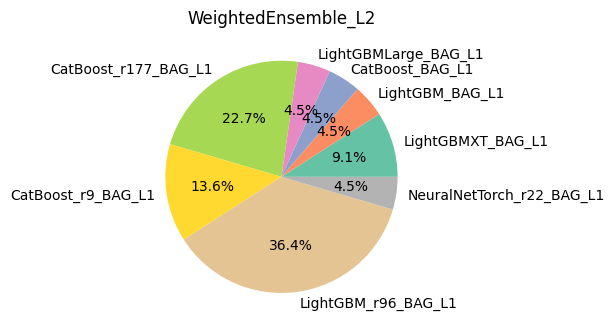

In [13]:
ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct="%1.1f%%", colors=sns.color_palette("Set2", len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

# Collecting and saving OOF files

In [14]:
joblib.dump(predictor.info()["features"], "features.pkl")

['features.pkl']

In [15]:
def save_preds(preds, cv_score, name, type, is_ensemble):
    base_path = "oof_preds" if type == "oof" else "test_preds"
    base_path = "." if is_ensemble else base_path
    joblib.dump(preds, f"{base_path}/{name}_{type}_preds_{cv_score:.6f}.pkl")

def save_submission(test_preds, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub["prediction"] = test_preds
    sub.to_csv(f"sub_autogluon_{score:.6f}.csv", index=False)
    
os.makedirs("oof_preds", exist_ok=True)
os.makedirs("test_preds", exist_ok=True)

In [16]:
oof_preds = {}
test_preds = {}

overall_scores = {}

In [17]:
def pearsonr(y_true, y_pred):
    return pr(y_true, y_pred)[0]

In [18]:
best_model = predictor.model_best
_test_preds = predictor.predict_multi(test)
for model in predictor.model_names():
    model_oof_preds = predictor.predict_oof(model).values
    model_test_preds = _test_preds[model].values
    
    cv_score = pr(train[CFG.target], model_oof_preds)[0]
    if model != best_model:
        save_preds(model_oof_preds, cv_score, model, "oof", False)
        save_preds(model_test_preds, cv_score, model, "test", False)
    else:
        save_preds(model_oof_preds, cv_score, model, "oof", True)
        save_preds(model_test_preds, cv_score, model, "test", True)
        save_submission(model_test_preds, cv_score)
        
    oof_preds[model] = model_oof_preds
    test_preds[model] = model_test_preds

    overall_scores[model] = [pr(model_oof_preds, train[CFG.target])[0]]

# Visualizing the results

In [19]:
fold_scores = {}
split = KFold(n_splits=CFG.n_folds, shuffle=False).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = pr(train.loc[val_index, CFG.target], oof_preds[model][val_index])[0]
        if model not in fold_scores:
            fold_scores[model] = []
        fold_scores[model].append(fold_score)

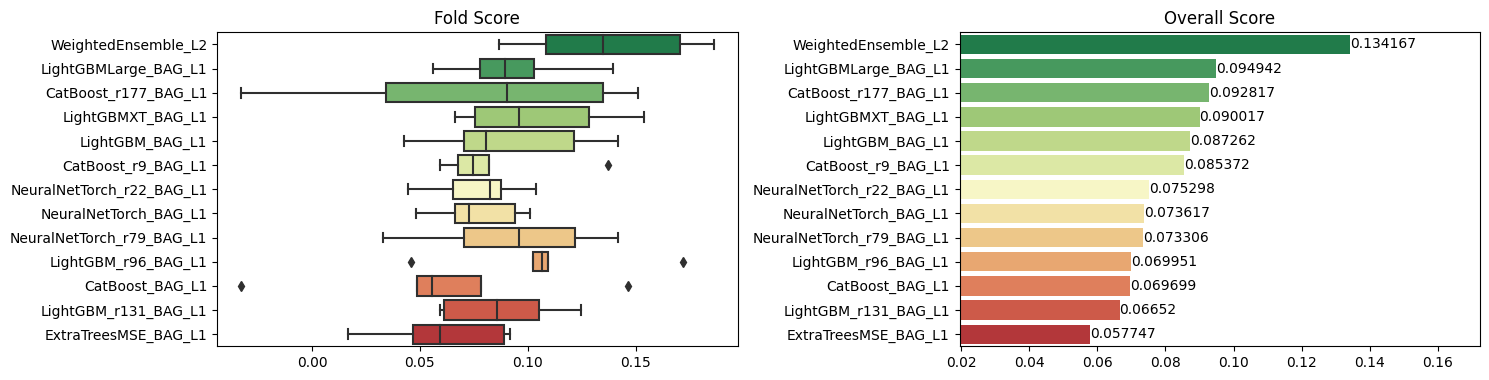

In [20]:
fold_scores = pd.DataFrame(fold_scores)
overall_scores = pd.DataFrame(overall_scores).transpose().sort_values(by=0, ascending=False)
order = overall_scores.index.tolist()

min_score = overall_scores.values.flatten().min()
max_score = overall_scores.values.flatten().max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, fold_scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=fold_scores, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title(f"Fold Score")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=overall_scores.values.flatten(), y=overall_scores.index, ax=axs[1], palette="RdYlGn_r")
axs[1].set_title(f"Overall Score")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(overall_scores.values.flatten(), overall_scores.index)):
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()